# Задание по EM-алгоритму

__Предупреждение про списывание.__ Строго запрещается использовать код других студентов в своем решении. Код из открытых источников разрешается брать только фрагментами по одной строке (например, скопировать пример использования какой-то функции), нельзя копировать код по несколько строк. В случае обнаружения похожих решений выставляется 0 за __все__ задание __обоим__ студентам, чьи работы являются похожими, и подается служебная записка в деканат.

## Теоретическая часть

__Теоретическая задача (Смесь мультиномиальных распределений), 2 балла__

Пусть $X=\{x_1, \dots, x_N\}$, $x_i \in \{1, 2, 3\}$  - независимая выборка из смеси двух мультиномиальных распределений:

$$p_1: \begin{matrix}
1 & 2 & 3\\
\alpha & 1-\alpha & 0
\end{matrix}
$$

$$
p_2: \begin{matrix}
1 & 2 & 3\\
0 & 1-\beta & \beta
\end{matrix}$$

В наблюдаемой выборке $X$ содержится 30 единиц, 20 двоек и 60 троек. Проведите первую итерацию ЕМ-алгоритма разделения смеси (Е-шаг и М-шаг) из начального приближения $\alpha_0 = \beta_0 = \gamma_0 = 0.5$. 

Скрытые переменные: $Z = \{z_1, \dots, z_N\}$, $z_i = [x_i \in p_1]$ (индикатор того, что i-й объект сгенерирован из первого распределения)

Вероятностная модель:

$$p(X, Z|\alpha, \beta, \gamma) = \prod_{i=1}^N p(x_i, z_i|\alpha, \beta, \gamma) = \prod_{i=1}^N \bigl(\gamma p_1(x_i|\alpha)\bigr)^{z_i} \bigl((1-\gamma) p_2(x_i|\beta)\bigr)^{1-z_i} $$

_Подсказки:_
* На Е-шаге найдите апостериорные вероятности $q_i = q(z_i=1) = p(z_i|x_i, \alpha, \beta, \gamma)$, рассмотрите три случая $x_i=1,2,3$ и для каждого вычислите соответствующее числовое значение величины $q_i$, используя начальное приближение.
* На M-шаге решите задачу $$\mathbb{E}_{q(Z)} \log ~ p(X, Z|\alpha, \beta, \gamma) = \sum_{i=1}^N \mathbb{E}_{q(z_i)} log ~p(x_i, z_i|\alpha, \beta, \gamma) \rightarrow \max_{\alpha, \beta, \gamma} $$ Вам потребуется мат. ожидание распределения Бернулли: $\mathbb{E}_{q(z_i)} z_i = q_i$. Сумма по объектам заменится на сумму по трем случаям $x_i=1,2,3$ с учетом количества выпадений каждого номера в выборке. Чтобы выполнить максимизацию, вычислите производную по параметрам, лангранжиан использовать не нужно. В результате этого шага у вас должны получиться числовые значения параметров $\alpha, \beta, \gamma$.
* Для самопроверки можете посчитать значения $q_i$ для следующего Е-шага, у вас должны получиться такие же значения, что на предыдущем шаге, что означает, что ЕМ-алгоритм сошелся за одну итерацию.

## Практическая часть

В этом задании вам предстоит реализовать EM-алгоритм для разделения смеси многомерных гауссиан, протестировать реализацию на синтетических данных и изображениях цифр и проанализировать результаты.

### Генерация синтетических данных

Для целей отладки будем использовать синтетические данные. Сгенерируем их с помощью sklearn:

In [22]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
%matplotlib inline

Text(0, 0.5, 'feature 2')

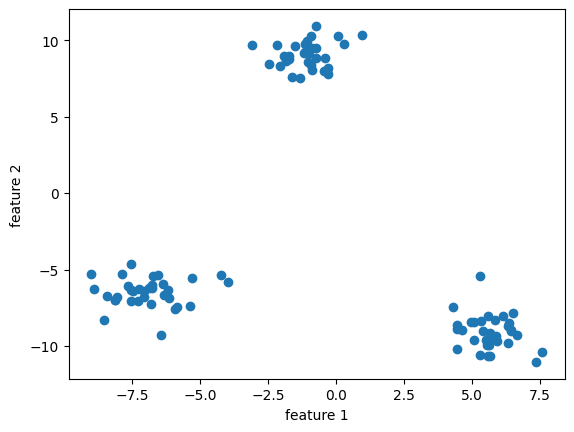

In [53]:
X, y = make_blobs()
plt.scatter(*X.T)
plt.xlabel("feature 1")
plt.ylabel("feature 2")

Если у вас сгенерировались "слипшиеся" гауссианы, перезапустите ячейку.

### Реализация EM-алгоритма для разделения смеси гауссиан

Как и при реализации многих других алгоритмов машинного обучения, нашим основным инструментом будет модуль numpy:

In [30]:
import numpy as np
import pandas as pd

## Задание 1 (5/5 баллов)

(5 баллов, выставляются только при наличии визуализации в следующей задаче)__ Реализуйте EM-алгоритм, следуя интерфейсу sklearn, см. прототип ниже. EM-алгоритм описан на слайде 48 в [презентации](https://github.com/ftad/BM2020/blob/master/materials/presentation_EM_ftad.pdf).

* Один из шагов EM-алгоритма разделения смеси включает подсчет матрицы ковариации. С этим поможет функция [np.cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html), пример использования дан ниже. Посмотрите документацию функции и обратите внимание на параметр, позволяющий задавать веса объектов!
* Один из шагов EM-алгоритма включает подсчет плотности многомерного нормального распределения. С этим поможет функция [scipy.stats.multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html).
* Чтобы избежать ошибки Singular matrix, сообщающей, что у какой-то гауссианы получилась вырожденная матрица ковариации, прибавляйте к вычисляемым матрицам ковариации единичную матрицу, умноженную на небольшой коэффициент (cov_reg в реализации).

Вов всех заданиях ниже рекомендуется использовать гиперпараметры, заданные по умолчанию, если не указано иное.

In [54]:
# example with np.cov
np.cov(X, rowvar=False)

array([[27.87116863, -6.91355468],
       [-6.91355468, 65.09836443]])

In [102]:
from scipy.stats import multivariate_normal
from sklearn.base import BaseEstimator

class GMM(BaseEstimator):
    def __init__(self, num_clusters=3, num_iters=100, cov_reg=1e-6):
        self.num_clusters = num_clusters
        self.num_iters = num_iters
        self.cov_reg = cov_reg

    def fit_transform(self, X):
        """
        * input: data matrix X, shape: [num_objects, num_features]

        The method runs EM-algorithm to fit
        a mixture of multinomial Gaussians on data.
        At the end of running, the following atributes should be learned:
        * self.mu: Gaussians' means, shape: [num_clusters, num_features]
        * self.sigma: Gaussians' covariance matrices,
                      shape: [num_clusters, num_features, num_features]
        * self.pi: prior misture weights, shape: [num_clusters]
                   self.pi should sum to 1
        The code for attribute initialization is given below

        The method returns:
        * y: posterior distribution over Gaussians for each objects,
             shape: [num_objects, num_clusters]
        """
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.mu = 2*np.random.rand(self.num_clusters, self.d) - 1
        self.sigma = np.concatenate([np.eye(self.d)[None, :, :] \
                     for k in range(self.num_clusters)], axis=0)
        self.pi = np.random.rand(self.num_clusters)
        self.pi /= self.pi.sum()

        for _ in range(self.num_iters):
            # E-step (Expectation)
            y = np.zeros((self.n, self.num_clusters))
            for k in range(self.num_clusters):
                y[:, k] = self.pi[k] * self._multivariate_normal_pdf(X, self.mu[k], self.sigma[k])

            y /= np.sum(y, axis=1, keepdims=True)  # Normalize y to sum to 1 for each object

            # M-Step (Maximization)
            Nk = np.sum(y, axis=0)
            self.pi = Nk / self.n
            self.mu = np.dot(y.T, X) / Nk[:, np.newaxis]
            self.sigma = np.zeros((self.num_clusters, self.d, self.d))
            for k in range(self.num_clusters):
                diff = X - self.mu[k]
                self.sigma[k] = np.dot((diff * y[:, k][:, np.newaxis]).T, diff) / Nk[k] + np.eye(self.d) * self.cov_reg

        return y

    def _multivariate_normal_pdf(self, X, mu, sigma):
        diff = X - mu
        inv_sigma = np.linalg.inv(sigma)
        det_sigma = np.linalg.det(sigma)
        exp_term = np.exp(-0.5 * np.sum(np.dot(diff, inv_sigma) * diff, axis=1))
        return (1 / np.sqrt((2 * np.pi) ** self.d * det_sigma)) * exp_term

# Тестирование EM-алгоритма на синтетических данных


## 2 (0.5/0.5 балла, включая вопрос ниже)

Протестируйте вашу реализацию на синтетических данных, сгенерированных выше в ноутбуке: запустите алгоритм на данных X с числом гауссиан, равным 3, __визуализируйте__, к какому кластеру отнесен каждый объект (получится трехцветный scatter-plot в осях двух признаков), а также __визуализируйте__ средние обученных гауссиан (на этом же графике). Чтобы определить принадлежность объекта к кластеру, используйте максимум апостериорной вероятности. Для получения хорошего результата может понадобиться перезапустить EM-алгоритм из другой начальной инициализации.

In [56]:
# Initialize GMM
em = GMM()

# Fitting model
result_clusters = em.fit_transform(X)

# Get the cluster indices for each data point
clusters = result_clusters.argmax(axis=1)

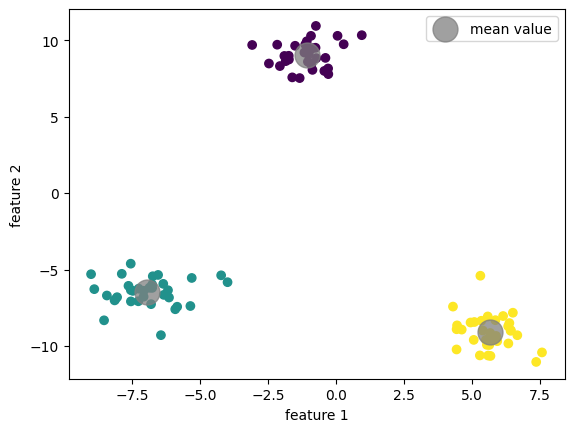

In [57]:
plt.scatter(
    X[:, 0], 
    X[:, 1], 
    c=clusters
)

plt.scatter(
    np.array(em.mu)[:, 0], 
    np.array(em.mu)[:, 1], 
    label='mean value',
    s=322, alpha=0.75, c=['grey'],
)

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend()
plt.show()

__Вопрос:__ получились ли матрицы ковариации, близкие к тем, которые использовались при генерации случайных данных?


In [58]:
### your code here (for question)
for k in range(3):
  print(em.sigma[k])

[[0.64263518 0.10136167]
 [0.10136167 0.71450833]]
[[1.35021861 0.058642  ]
 [0.058642   0.84365109]]
[[ 0.61629344 -0.22311576]
 [-0.22311576  1.21409342]]


In [59]:
for k in range(3):
  print(np.cov(X[y==k], rowvar=False))

[[1.39113433 0.06041903]
 [0.06041903 0.86921627]]
[[0.66271753 0.10452922]
 [0.10452922 0.73683672]]
[[ 0.63555261 -0.23008813]
 [-0.23008813  1.25203384]]



__Ответ:__ Как видим, имеем почти идентичные матрицы ковариаций

## Задание 3 (0.5/0.5 балла)

EM-алгоритм выполняет "мягкую" кластеризацию: для каждого объекта определяется, с какой вероятностью он принадлежит к каждому из кластеров, вместо того, чтобы выбирать один кластер ("жесткая" кластеризация). Чтобы иллюстрировать это свойство, используем EM-алгоритм для разделения двух близко расположенных гауссиан. Сгенерируем такие данные:

Text(0, 0.5, 'feature 2')

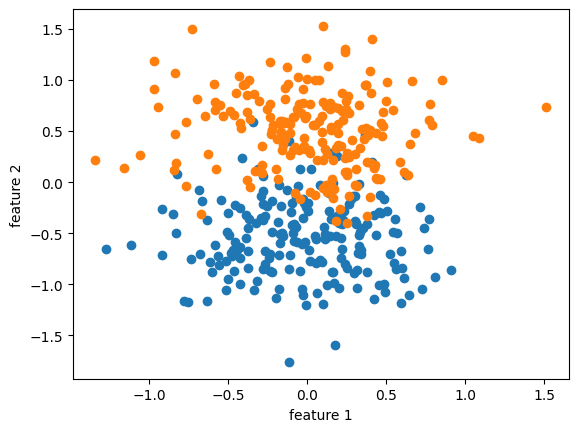

In [60]:
X0 = np.random.multivariate_normal([0, -0.5], 0.15*np.eye(2), size=200)
X1 = np.random.multivariate_normal([0, 0.5], 0.15*np.eye(2), size=200)
X2 = np.vstack([X0, X1])
plt.scatter(*X0.T)
plt.scatter(*X1.T)
plt.xlabel("feature 1")
plt.ylabel("feature 2")

Обучите вашу реализацию EM-алгоритма с числом гауссиан, равным 2, на сгенерированных данных. Сделайте __две__ визуализации: одна для жесткой кластеризации (цвета показывают, к какому кластеру отнесен каждый объект - аналогично предыдущей визуализации) и одна для мягкой кластеризации (цвета показывают апостериорную вероятность первой гауссианы). __Сделайте выводы из этих визуализаций.__ Для получения хорошего результата может понадобиться перезапустить EM-алгоритм из другой начальной инициализации.

In [63]:
# Initialize GMM
em_2cl = GMM(num_clusters=2)

# Fitting model
result_clusters_2 = em_2cl.fit_transform(X2)

# Get the cluster indices for each data point
clusters_2 = result_clusters_2.argmax(axis=1)

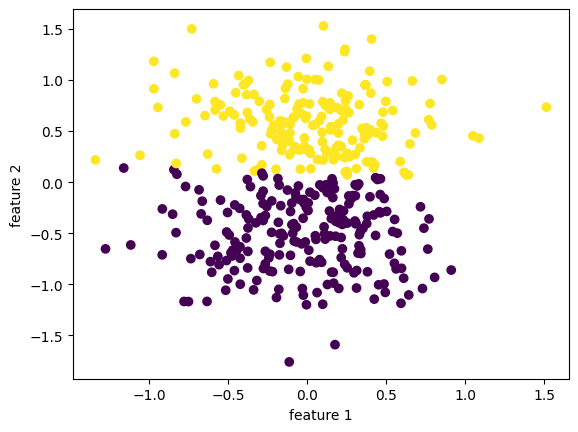

In [64]:
plt.scatter(
    X2[:, 0], 
    X2[:, 1], 
    c=clusters_2
)

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

__Вывод:__ 

При использовании EM-алгоритма с жесткой кластеризацией наблюдается явное разделение данных по гиперплоскости, которая проходит вдоль линии, где значение "feature 2" равно нулю.

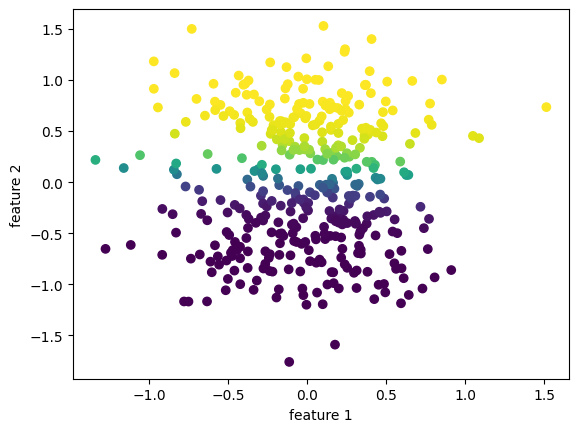

In [65]:
plt.scatter(
    X2[:, 0], 
    X2[:, 1], 
    c=result_clusters_2[:, 1]
)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

__Вывод:__ 

В случае мягкой кластеризации мы замечаем, что точки, находящиеся рядом с этой линией, постепенно приобретают синий/зеленый цвет по мере приблежения значения "feature 2" к нулю. => там алгоритм не может однозначно определить

## Тестирование EM-алгоритма на данных с изображениями

Теперь протестируем реализацию на данных изображений цифр. Будем использовать стандартный набор данных digits. Нормируем данные (для численной устойчивости) и обрежем рамку толщиной один пиксель (также для численной устойчивости).

In [66]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

In [67]:
digits = load_digits()
X_dig = digits["data"]
y_dig = digits["target"]
X_dig.shape

(1797, 64)

In [68]:
scaler = StandardScaler()
X_dig_sc = scaler.fit_transform(X_dig)

In [69]:
X_dig_cr = X_dig_sc.reshape(-1, 8, 8)[:, 1:-1, 1:-1].\
                    reshape(X_dig_sc.shape[0], -1)

## Задание 4 (каждый пункт 1 балл) (2/2 балла)

Примените EM-алгоритм к данным, использовав число гауссиан, равное 10. 


In [313]:
# Initialize GMM
em_10cl = GMM(num_clusters=10, num_iters=100)

# Fitting model
result_clusters_10 = em_10cl.fit_transform(X_dig_cr)

# Get the cluster indices for each data point
clusters_10 = result_clusters_10.argmax(axis=1)

### 1) (1/1 балла)

Изобразите средние всех десяти гауссиан в виде изображений 6x6, подписав (в plt.title) номер гауссианы. Напечатайте, к какому кластеру отнесены первые 10 объектов выборки. Напечатайте их классы согласно данным. Можно ли сказать, что какие-то кластеры соответствуют конкретным цифрам? Какие? Приветствуется другой анализ визуализации. Может потребоваться перезапустить EM-алгоритм.


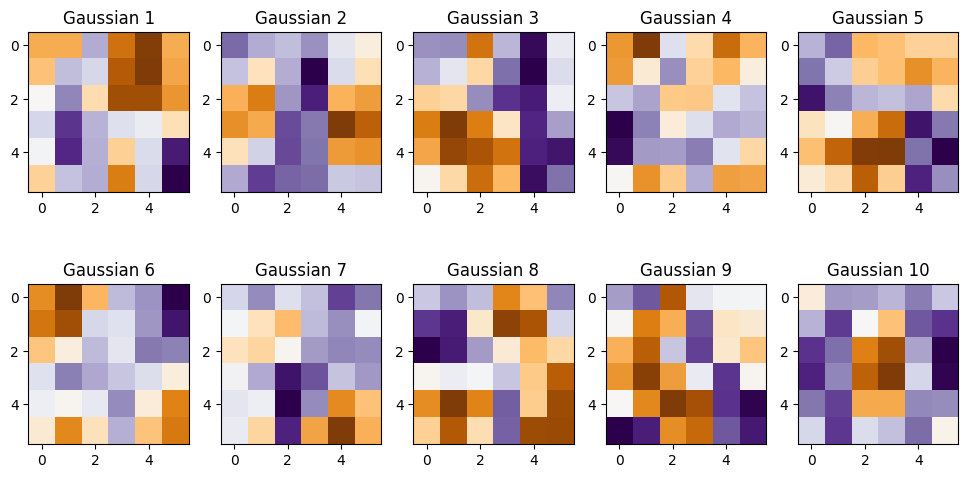

Классы первых 10 объектов выборки:
Объект 0 - кластер 9
Объект 1 - кластер 1
Объект 2 - кластер 1
Объект 3 - кластер 2
Объект 4 - кластер 3
Объект 5 - кластер 2
Объект 6 - кластер 0
Объект 7 - кластер 6
Объект 8 - кластер 1
Объект 9 - кластер 4


In [314]:
import matplotlib.pyplot as plt

means = em_10cl.mu  # Средние значения гауссиан
covariances = em_10cl.sigma  # Ковариации гауссиан

fig, axs = plt.subplots(2, 5, figsize=(12, 6))
k = 0

for i in range(2):
    for j in range(5):
        image = means[k].reshape(6, 6)  # Преобразование среднего значения гауссианы в форму 6x6
        axs[i, j].imshow(image, cmap='PuOr')
        axs[i, j].set_title(f"Gaussian {k + 1}")
        k += 1
        
plt.show()

# Вывод классов первых 10 объектов выборки
print("Классы первых 10 объектов выборки:")
for i in range(10):
    print(f"Объект {i} - кластер {clusters_10[i]}")

In [315]:
full_stats = pd.DataFrame()
full_stats['real'] = y_dig
full_stats['pred'] = clusters_10
full_stats['counter'] = 1

full_stats.pivot_table(index='real', columns='pred', aggfunc='sum')

counter                                                           
pred       0      1      2      3     4     5      6     7     8      9
real                                                                   
0        NaN    NaN    NaN    NaN   4.0   6.0    NaN   NaN   NaN  168.0
1        NaN   99.0   28.0   12.0   NaN  40.0    3.0   NaN   NaN    NaN
2        2.0  166.0    NaN    NaN   4.0   5.0    NaN   NaN   NaN    NaN
3        NaN   37.0   84.0    1.0   8.0   5.0    NaN   1.0  47.0    NaN
4        NaN    NaN    NaN  139.0   NaN  12.0    8.0  22.0   NaN    NaN
5        4.0    NaN    1.0    1.0  54.0   1.0   19.0  95.0   6.0    1.0
6      163.0    NaN    NaN   16.0   2.0   NaN    NaN   NaN   NaN    NaN
7        NaN    2.0    NaN    2.0   NaN  34.0  132.0   NaN   NaN    9.0
8        2.0  130.0   29.0    1.0   1.0   3.0    5.0   2.0   1.0    NaN
9        NaN    3.0  118.0    NaN  17.0   5.0    1.0  19.0   6.0   11.0

In [160]:
from tqdm import trange, tqdm

In [ ]:
stat_res = {i: [] for i in range(1, 11)}

for _ in trange(10000):
    em_10cl = GMM(num_clusters=10, num_iters=100)
    result_clusters_10 = em_10cl.fit_transform(X_dig_cr)
    clusters_10 = result_clusters_10.argmax(axis=1)

    for i in range(1, 11):
        stat_res[i].append(clusters_10[i])

In [ ]:
from collections import Counter

In [ ]:
for i in range(1, 11):
    print(Counter(stat_res[i]))

Counter({2: 115, 1: 105, 3: 102, 4: 101, 9: 98, 0: 97, 5: 93, 7: 91, 8: 87, 6: 85})
Counter({7: 112, 5: 108, 2: 106, 9: 106, 4: 100, 3: 95, 1: 93, 8: 88, 0: 86, 6: 80})
Counter({2: 120, 3: 107, 5: 103, 7: 97, 6: 96, 9: 93, 1: 93, 8: 91, 4: 89, 0: 85})
Counter({4: 115, 7: 106, 9: 102, 1: 98, 3: 94, 8: 94, 5: 93, 0: 91, 2: 91, 6: 90})
Counter({2: 109, 0: 104, 5: 103, 9: 102, 6: 98, 8: 97, 1: 94, 7: 91, 3: 89, 4: 87})
Counter({8: 123, 6: 106, 5: 105, 9: 103, 1: 100, 0: 100, 7: 91, 2: 86, 4: 80, 3: 80})
Counter({7: 116, 3: 113, 4: 104, 9: 100, 5: 96, 0: 94, 8: 92, 2: 92, 1: 89, 6: 78})
Counter({6: 111, 4: 103, 7: 102, 3: 101, 1: 100, 8: 95, 0: 93, 9: 91, 5: 90, 2: 88})
Counter({9: 119, 0: 114, 1: 114, 5: 101, 2: 97, 7: 92, 3: 91, 4: 88, 8: 80, 6: 78})
Counter({4: 119, 5: 107, 7: 101, 6: 101, 0: 101, 2: 99, 1: 96, 8: 89, 3: 83, 9: 78})


Думал сделать так, но потом понял, что названия классов переопределяются от каждого fit_transform, поэтому все выводы далее для первой прогонки

__Выводы к пункту 1:__ 

1, 3, 9 алгоритм предсказывает сложнее всего (с трудом)

0 и 2 - наиболее рапозноваемые и соотносятся с 9 и 1 соответственно

остальные менее точно можно определить, но все же:

0 - 9

1 - 1/2/5

2 - 1

3 - 1/2/8

4 - 3

5 - 4/7

6 - 0

7 - 5/6

8 - 1/2

9 - 2/4/7

### 2) (1/1 балла)

 Найдите несколько объектов (>=3), у которых максимальная апостериорная вероятность меньше 0.9. Визуализируйте эти объекты в виде изображений 6x6, определите для них две наибольшие предсказанные апостериорные вероятности. Можно ли проинтерпретировать, почему эти объекты находятся на "границе" кластеров? Как? Чтобы найти >=3 объектов, удовлетворяющих условию, может потребоваться перезапустить EM-алгоритм. В этом случае сделайте отдельную визуализацию средних гауссиан для нового запуска.

In [316]:
d = np.where(result_clusters_10.max(axis=1) < 0.9)

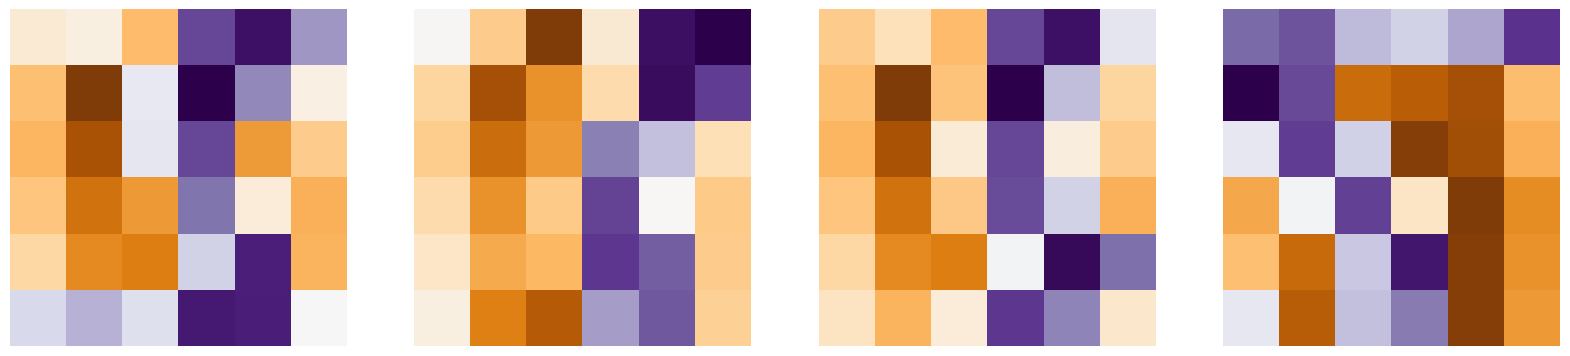

In [318]:
objects = X_dig_cr[d]

# Visualize the images
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, ax in enumerate(axs):
    ax.imshow(objects[i].reshape(6, 6), cmap='PuOr')
    ax.axis('off')

plt.show()

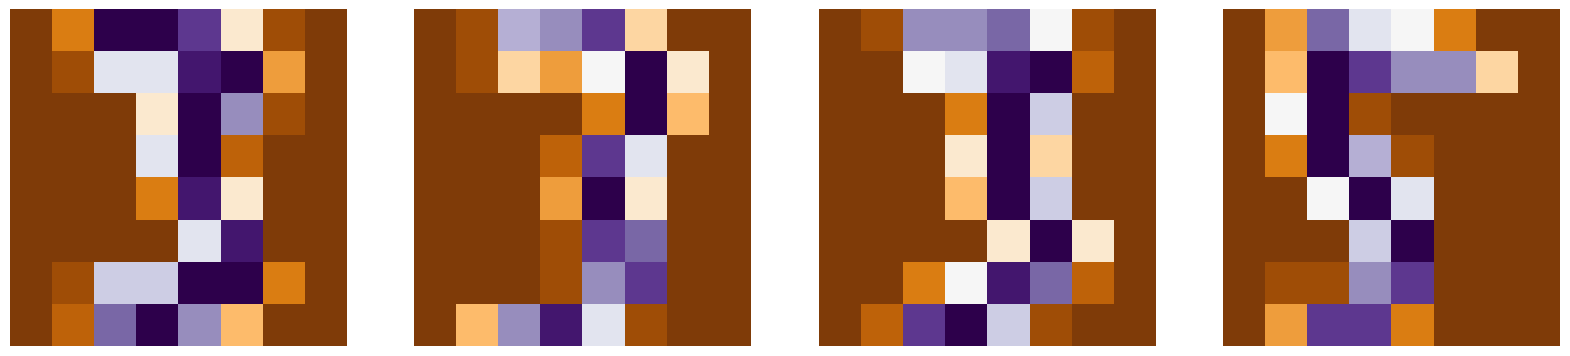

In [323]:
objects_based = X_dig[d]

# Visualize the images
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, ax in enumerate(axs):
    ax.imshow(objects_based[i].reshape(8, 8), cmap='PuOr')
    ax.axis('off')

plt.show()

In [320]:
top2_indexes = result_clusters_10[d].argsort(1)[:, :-3:-1]
for i in range(top2_indexes.shape[0]):
    cluster = top2_indexes[i]
    probas = np.take(result_clusters_10[d][i], cluster)
    print(f'clusters = {cluster}, probas = {probas}')

clusters = [1 2], probas = [0.89725954 0.10274046]
clusters = [2 1], probas = [0.79492703 0.20507297]
clusters = [1 2], probas = [0.88865572 0.11134428]
clusters = [6 7], probas = [0.82446826 0.17553174]


__Выводы к пункту 2:__ 

Ну данные картинки можно принять почти за что угодно, хотя я бы:

на второй картинке склонялся бы к 2 или 3, что полностью подходит определенным класстером моделью

на 4 я бы склонялся к 5, которая есть в 6 и 7 кластерах. 

Поэтому я бы сказал, что модель справилась с поставленной задачей; хотя мне как человеку это удается с трудом на нормальной 8x8, а ей нормально на шакальной 6x6